<a href="https://colab.research.google.com/github/onezerobinary/ml-pneunomia-classifier/blob/master/pneumonia_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classifier

In this notebook we are going to apply Transfer Learning to classify some
chest X-ray images that has or not pneumonia.


We will be using a pretrained Inception V3 model taken from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). 

## Setup Colab Environment

In [0]:
# Fundamentals libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

In [0]:
# Mount the Drive if in Google Colaboratory
try:
    from google.colab import drive
except:
    pass

In [0]:
# Tensorflow and Keras 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [0]:
# Utils 
from itertools import product
from functools import partial

In [5]:
# Since I am running this notebook on Colab, 
# Let's try and get some system information 
import platform
print('System Processor: ', platform.processor(), '\n')
!nvidia-smi

System Processor:  x86_64 

Sat Sep 28 09:09:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
filepath = '/content/drive/My Drive/ml/week4/chest_xray'


train_dir =  filepath + '/train/'
validation_dir = filepath + '/val/'
test_dir = filepath + '/test/'

Try to display an image

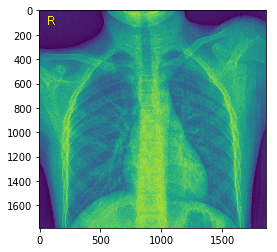

In [8]:
img = mpimg.imread(test_dir + 'NORMAL/IM-0011-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Show some more images taken from different sources.

In [0]:
# Normal 
img_normal = plt.imread(f'{test_dir}NORMAL/IM-0110-0001.jpeg')
# Bacterial
img_penumonia_bacteria = plt.imread(f'{test_dir}PNEUMONIA/person101_bacteria_486.jpeg')
# Viral
img_penumonia_virus = plt.imread(f'{test_dir}PNEUMONIA/person1685_virus_2903.jpeg')

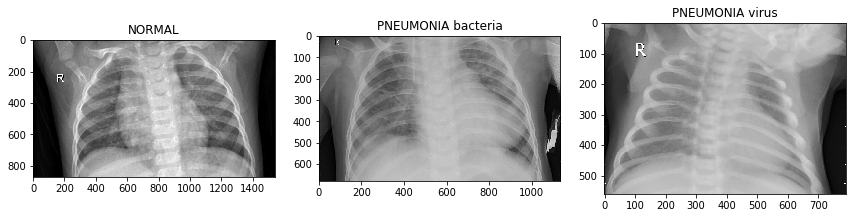

In [10]:
# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA bacteria')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA virus')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

## Building a Model using Inception v3
We will be doing transfer learning using the Inception V3 pretrained model.

In [0]:
# The number of classes we are trying to classify are 2
# Normal or Pneumonia
NUM_CLASSES = 2

# Build the Model
def create_model(input_shape, num_classes):
  """
  Creates the image classifier model on top of a
  pretrained Inception v3.

  Parameters
  ----------
  input_shape : Tuple    
      Shape tuple for Inception v3
  
  num_classes : Integer
      The number of classes that the classifier is 
      going to classify

  Returns
  -------
  The tensorflow model.  
  """
  # We start with a blank slate
  K.clear_session()
   # Inception v3 is our base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  # Add our custom layers on top for classification
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  # We are using the base model only for feature extraction
  # So we make sure the layer weights don't change 
  for layer in base_model.layers:
    layer.trainable = False

  # The final predictions layer is going to be a dense layer
  # with Sigmoid activations - predicts only 'num_classes'    
  predictions = Dense(num_classes, activation='sigmoid')(x)
  # Instantiate the model 
  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model


# Creat the model with Height & Width as 150 and 3 channels for Inception
# And we are going to predict only 2 classes in our case
model = create_model((150, 150, 3), NUM_CLASSES)

In [20]:
# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
# Test Loss 
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
# Test Accuracy 
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Compile the model

In [0]:
# We use the standard Adam Optimizer 
optimizer = Adam(lr=0.0001)

# Compile 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy']
             )

## Try to avoid Overfitting

In [0]:
def dir_file_count(directory):
  """
  Counts the total number of files in a directory. 

  Parameters
  ----------
  directory : String    
      The directory isnide which the function is going
      to count the number of files 
  
  Returns
  -------
  Total number of files present inside the 'directory'.  
  """
  return sum([len(files) for r, d, files in os.walk(directory)])

In [23]:
# Configuration parameters 
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

# Augment the Training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the Model
Now it's time to train the model 🙌 for about 50 epochs 🤞



In [0]:
# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=50,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

# Save the model after the training is complete
MODEL_FILE = 'my_pneumonia_model.hd5'
model.save(MODEL_FILE)

# Move the trained model to the Google Drive 
!mv {MODEL_FILE} '/content/drive/My Drive/ml/week4/'

Epoch 1/50
11/11 [==============================] - 63s 6s/step - loss: 0.2484 - acc: 0.8967 - val_loss: 1.6028 - val_acc: 0.6875
Epoch 2/50
11/11 [==============================] - 58s 5s/step - loss: 0.2458 - acc: 0.9001 - val_loss: 2.1289 - val_acc: 0.5625
Epoch 3/50
11/11 [==============================] - 59s 5s/step - loss: 0.2435 - acc: 0.9015 - val_loss: 2.5344 - val_acc: 0.5625
Epoch 4/50


## Evaluate the Model
Now that we have our trained model it's time to see how well it does on the training data set.

In [26]:
# Load the Model from Google Drive 
MODEL_FILE = f'/content/drive/My Drive/ml/week4/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 269s 269s/step - loss: 1.2199 - acc: 0.6827
Loss     : 1.22  
Accuracy : 68.27%


Now lets evaluate the model and make the predictions on randomly chosen batches from the test dataset.

In [28]:
# Randomly generate the Test Batch No
num_of_batch = len(test_generator) # This is 1 in our case 
batch_no = random.randint(0, num_of_batch - 1)

# Fetch the batch data
y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

# Make the predictions 
y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

# Print the results 
print("-"*42)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*42)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*42)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*42)

------------------------------------------
Selected Batch No       : 0
------------------------------------------
Batch Size              : 624
------------------------------------------
Accuracy                : 68.27%
------------------------------------------
